In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2022-09-06 12:20:40.942905: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 12:20:41.005061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 12:20:41.005083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocessing, Target Engineering and RNN model with Word2Vec embedding 
### on final Data Set from OpenAlex

In [3]:
# Reading Data
data = pd.read_csv('../raw_data/data_3k.csv')
data = data.drop(columns='Unnamed: 0')
data.head()

,id,title,text,topic,subtopic
0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


In [4]:
# Dropping duplicates
data.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
data.shape

(2867, 5)

#### Further data cleaning is not necessary, since we built this dataset ourselves.

## Preprocessing

In [5]:
# Lowercasing everything
data = data.apply(lambda x: x.astype(str).str.lower())

In [6]:
# Removing anything apart from lower case letters 
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

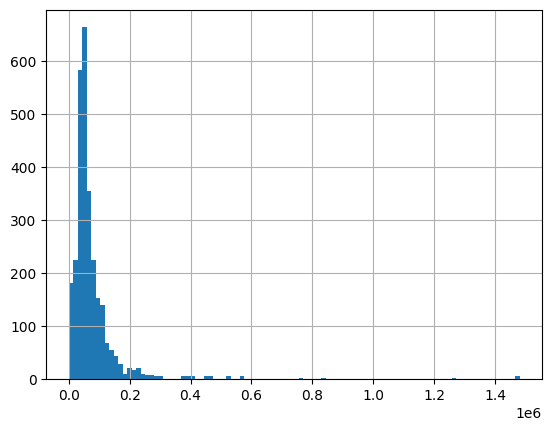

In [7]:
# This is the distribution of the total number of words per paper
data['total words per text'] = data['text'].apply(lambda x : len(x)) 
data['total words per text'].hist(bins=100);

#### In terms of computational efficiency it is reasonable to scale down the number of word taken into account from every paper. Otherwise, the file wouldn't be executable.

#### We will do so by creating a reduced list of tokens from the paper texts, that we will later use for word embedding. To increase the quality we will remove stopwords and singel letter words.

In [8]:
# Tokenizing
max_length_of_padding = 1000 # to save computational costs, we will already implement the max_length_of_padding here
num_of_words_to_keep = int(max_length_of_padding*5) # adding some margin, because in spotword removal and word2vec embedding some will be removed

data['modified text'] = data['text'].apply(lambda text: ' '.join(text.split()[:num_of_words_to_keep]))
data['modified text'] = data['modified text'].apply(word_tokenize)

In [9]:
# Removing stopwords and single letter words
stop_words = set(stopwords.words('english'))

data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if not word in stop_words])
data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if len(word)>1])

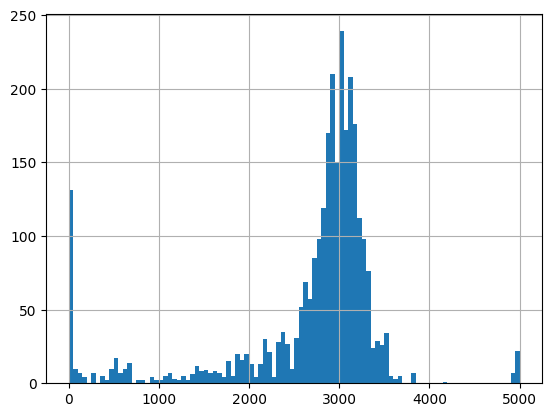

In [10]:
# This is the distribution of numbers of selected tokens per paper after cutting down
data['words per modified text'] = data['modified text'].apply(lambda x : len(x)) 
data['words per modified text'].hist(bins=100);

In [11]:
# Let's also exclude representations with less than 10 tokens
data = data[data['words per modified text'] > 9].reset_index().drop(columns=['index'], axis=1)
data.shape

(2752, 8)

#### Now we will clean our data some more by reducing the samples of uncommon targets.

## Taking Care of the Targets

In [12]:
# Let's check how our topics and subtopics are distributed
data['topic'].value_counts()

biology                  884
medicine                 660
chemistry                247
psychology               223
computer science         214
physics                  110
materials science         94
mathematics               72
environmental science     67
economics                 51
business                  40
geology                   33
geography                 21
sociology                 13
political science         10
engineering                9
history                    2
philosophy                 1
art                        1
Name: topic, dtype: int64

#### Topics are highly imballanced, we'll have to take care of this later.

In [13]:
# Now checking the counts of the subtopics
data['subtopic'].value_counts()

cell biology           196
internal medicine      147
genetics               132
immunology             111
neuroscience           110
                      ... 
regional science         1
classical economics      1
actuarial science        1
speech recognition       1
political economy        1
Name: subtopic, Length: 235, dtype: int64

In [14]:
# Inspecting the relationship between topics and subtopics
data.groupby(by=['topic', 'subtopic']).count()

id  title  text  total words per text  \
topic     subtopic                                                       
art       theology                1      1     1                     1   
biology   agroforestry            2      2     2                     2   
          algorithm               2      2     2                     2   
          anatomy                11     11    11                    11   
          andrology               3      3     3                     3   
...                              ..    ...   ...                   ...   
sociology management science      1      1     1                     1   
          mathematics education   1      1     1                     1   
          public relations        3      3     3                     3   
          social psychology       1      1     1                     1   
          social science          2      2     2                     2   

                                 modified text  words per modified text  
topic     subtopic                                                       
art       theology                           1                        1  
biology   agroforestry                       2                        2  
          algorithm                          2                        2  
          anatomy                           11                       11  
          andrology                          3                        3  
...                                        ...                      ...  
sociology management science                 1                        1  
          mathematics education              1                        1  
          public relations                   3                        3  
          social psychology                  1                        1  
          social science                     2                        2  

[529 rows x 6 columns]

In [15]:
# Remark on the subtopics
num_subtopics = len(data['subtopic'].value_counts())
num_subtopics_grouped_by_topics = len(data.groupby(by=['topic', 'subtopic']).count())

print(f'Since the number of subtopics is {num_subtopics} and the number subtopics grouped by their topics increases to {num_subtopics_grouped_by_topics}, we can deduce, that we have subtopics, that belong to several academic fields.')

Since the number of subtopics is 235 and the number subtopics grouped by their topics increases to 529, we can deduce, that we have subtopics, that belong to several academic fields.


#### Which are these? And how common are those multiclass subtopics?

In [16]:
# Getting the subtopics that are attributed to several topics
def finding_multiassigned_subtopics():
    list_of_multiclass_subtopics = []
    for i in range(len(data.groupby(by=['subtopic', 'topic']).count())-1):
        if (data.groupby(by=['subtopic', 'topic']).count().index[i][0] == \
            data.groupby(by=['subtopic', 'topic']).count().index[i+1][0]):
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i])
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i+1])

    return list(set(list_of_multiclass_subtopics))

In [17]:
# Which multiclass assigned subtopics are the most common ones?
multiclass_subtopics = finding_multiassigned_subtopics()

df = pd.DataFrame()
for i in range(len(multiclass_subtopics)):
    extracted_data = (data[(data['subtopic'] == multiclass_subtopics[i][0]) & (data['topic'] == multiclass_subtopics[i][1])])
    extracted_data_old = df
    df = pd.concat([extracted_data_old, extracted_data], ignore_index=True)
df = df.sort_values(by='subtopic')

df.groupby(by="subtopic").count().sort_values(by='id', ascending=False)

,id,title,text,topic,total words per text,modified text,words per modified text
subtopic,,,,,,,
cell biology,196,196,196,196,196,196,196
internal medicine,147,147,147,147,147,147,147
genetics,132,132,132,132,132,132,132
immunology,111,111,111,111,111,111,111
neuroscience,110,110,110,110,110,110,110
...,...,...,...,...,...,...,...
environmental planning,2,2,2,2,2,2,2
economic system,2,2,2,2,2,2,2
environmental ethics,2,2,2,2,2,2,2


#### We can see that some interdisciplinary subtopics (those with high transfer potential) tend to live in several academic fields.

In [18]:
# example subtopic 'cell biology' 
df[df['subtopic'] == 'cell biology']['topic'].value_counts()

biology              143
chemistry             45
mathematics            3
computer science       2
medicine               2
materials science      1
Name: topic, dtype: int64

#### We want to join some of the subtopics, so that we have lesser and larger subtopics to classify.

### Reducing the subtopics

In [19]:
# Printing the subtopics from the field "physics", for matching purposes
print(Counter(data[data['topic'] == 'physics']['subtopic']))

Counter({'astronomy': 32, 'quantum mechanics': 7, 'classical mechanics': 7, 'astrophysics': 5, 'neuroscience': 4, 'theoretical physics': 4, 'computational physics': 4, 'mechanics': 4, 'condensed matter physics': 4, 'statistical physics': 3, 'nuclear physics': 3, 'optics': 3, 'geometry': 2, 'systems engineering': 2, 'atomic physics': 2, 'mathematical physics': 2, 'astrobiology': 2, 'quantum electrodynamics': 2, 'particle physics': 2, 'biological system': 2, 'chemical physics': 1, 'electrical engineering': 1, 'simulation': 1, 'applied mathematics': 1, 'electronic engineering': 1, 'nuclear medicine': 1, 'optoelectronics': 1, 'nanotechnology': 1, 'molecular physics': 1, 'physical medicine and rehabilitation': 1, 'geochemistry': 1, 'pure mathematics': 1, 'meteorology': 1, 'thermodynamics': 1})


In [20]:
# Make a mapping of physics subtopics from our api data to more generalised physics subtopics
physics_mapping_dict = {'astrophysics': ['astronomy', 'astrophysics', 'astrobiology'],\
    'condensed matter': ['condensed matter', 'statistical physics', 'neuroscience', 'biological system', 'nanotechnology', 'molecular physics', 'computational physics'],\
    'general relativy and cosmology': ['classical mechanics', 'mechanics', 'optics'],\
    'high enery physics': ['atomic physics', 'particle physics'],\
    'mathematical physics': ['geometry', 'mathematical physics', 'applied mathematics', 'theoretical physics', 'pure mathematics'],\
    'nuclear': ['nuclear physics', 'nuclear medicine', 'physical medicine and rehabilitation'],\
    'quantum physics': ['quantum mechanics', 'quantum electrodinamics']}

In [21]:
# Turning the dict, which as accidentally coded the wrong way around
def turn_dict(physic_dict):
    new_dict = {}
    for key, values in physic_dict.items():
        for value in values:
            new_dict[value]=key
    return new_dict

new_mapping_dict = turn_dict(physics_mapping_dict)
new_mapping_dict

{'astronomy': 'astrophysics',
 'astrophysics': 'astrophysics',
 'astrobiology': 'astrophysics',
 'condensed matter': 'condensed matter',
 'statistical physics': 'condensed matter',
 'neuroscience': 'condensed matter',
 'biological system': 'condensed matter',
 'nanotechnology': 'condensed matter',
 'molecular physics': 'condensed matter',
 'computational physics': 'condensed matter',
 'classical mechanics': 'general relativy and cosmology',
 'mechanics': 'general relativy and cosmology',
 'optics': 'general relativy and cosmology',
 'atomic physics': 'high enery physics',
 'particle physics': 'high enery physics',
 'geometry': 'mathematical physics',
 'mathematical physics': 'mathematical physics',
 'applied mathematics': 'mathematical physics',
 'theoretical physics': 'mathematical physics',
 'pure mathematics': 'mathematical physics',
 'nuclear physics': 'nuclear',
 'nuclear medicine': 'nuclear',
 'physical medicine and rehabilitation': 'nuclear',
 'quantum mechanics': 'quantum physi

In [22]:
# Mapping the subtopics from the mapping dict to the broader subtopics
data['broader_subtopic'] = data.where(data['topic'] == 'physics')['subtopic'].map(new_mapping_dict)
data[data['topic'] == 'physics'].head()

,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,broader_subtopic
40,https://openalex.org/w1955575446,sharp wave-associated high-frequency oscillati...,the journal of neuroscience january ...,physics,neuroscience,90278,"[journal, neuroscience, january, sharp, wave, ...",3150,condensed matter
43,https://openalex.org/w2025236523,entanglement measures and purification procedures,physical review a volume number march ...,physics,quantum mechanics,102312,"[physical, review, volume, number, march, enta...",2857,quantum physics
48,https://openalex.org/w2102582588,the peregrine soliton in nonlinear fibre optics,letters published online august do...,physics,quantum mechanics,32391,"[letters, published, online, august, doi, nphy...",2836,quantum physics
56,https://openalex.org/w2005241888,constant temperature molecular dynamics methods,progress of theoretical physics supplement no...,physics,statistical physics,123550,"[progress, theoretical, physics, supplement, c...",2230,condensed matter
93,https://openalex.org/w1969658805,on the measurement of a weak classical force c...,on the measurement of a weak classical fo...,physics,quantum mechanics,306620,"[measurement, weak, classical, force, coupled,...",2827,quantum physics


In [23]:
# Checking if it worked
data['broader_subtopic'].value_counts()

astrophysics                      39
condensed matter                  15
general relativy and cosmology    14
mathematical physics              10
quantum physics                    7
nuclear                            5
high enery physics                 4
Name: broader_subtopic, dtype: int64

### Getting rid of rare topics and subtopics

In [24]:
# Filtering for those topics that occurr more commonly in our data        <----- percentile can be adjusted
common_topics = (data['topic'].value_counts() > np.percentile(data['topic'].value_counts(), 25)) # topic occurrence until 25th percentile
filtered_topics = common_topics[common_topics == True].index
filtered_topics

Index(['biology', 'medicine', 'chemistry', 'psychology', 'computer science',
       'physics', 'materials science', 'mathematics', 'environmental science',
       'economics', 'business', 'geology', 'geography', 'sociology'],
      dtype='object')

In [25]:
# Filtering for those subtopics that occurr more commonly in our data     <----- instead of cutting of at the mean, can also be adjusted like above
common_subtopics = (data['subtopic'].value_counts() > data['subtopic'].value_counts().mean())
filtered_subtopics = common_subtopics[common_subtopics == True].index
filtered_subtopics

Index(['cell biology', 'internal medicine', 'genetics', 'immunology',
       'neuroscience', 'molecular biology', 'biochemistry',
       'computational biology', 'endocrinology', 'cancer research',
       'microbiology', 'gerontology', 'ecology', 'nanotechnology',
       'pediatrics', 'surgery', 'biophysics', 'psychiatry', 'physical therapy',
       'astronomy', 'cognitive psychology', 'cardiology',
       'evolutionary biology', 'virology', 'pathology', 'pharmacology',
       'algorithm', 'demography', 'bioinformatics', 'environmental health',
       'intensive care medicine', 'artificial intelligence',
       'gastroenterology', 'botany', 'anatomy', 'social psychology',
       'clinical psychology', 'developmental psychology', 'statistics',
       'data science', 'oncology', 'data mining', 'chemical engineering',
       'family medicine', 'gynecology', 'mathematical optimization',
       'audiology', 'atmospheric sciences', 'world wide web', 'econometrics',
       'crystallography'],

In [26]:
# Filtering data according to the topics and subtopics that are more common
#data = data[data['subtopic'].isin(list(filtered_subtopics)) & data['topic'].isin(list(filtered_topics))]
#data.shape

# There is a catch here though, because the occurrence of both, topics and subtopics, depend on each other.
# This might leave us with some scarcely represented topics and subtopics still.
# Should there be some time left before the deadline, this should be optimized.

In [27]:
# Filtering data according to the topics that are more common
data = data[data['topic'].isin(list(filtered_topics))]

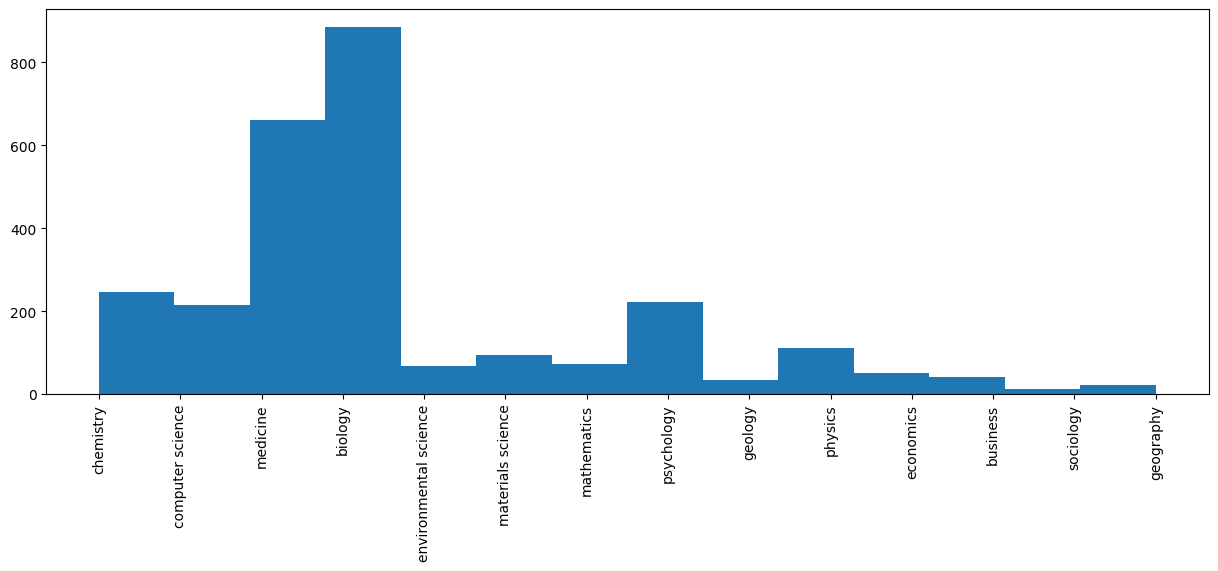

In [28]:
# The remaining topics and the subtopics are distributed as such:
plt.figure(figsize=(15, 5))
plt.hist(data['topic'], bins=data['topic'].nunique())
#plt.hist(data['subtopic'], bins=data['subtopic'].nunique())
plt.xticks(rotation = 90)
plt.show()

In [29]:
# Printing precise number of occurances for each topic
print(Counter(data['topic']))

Counter({'biology': 884, 'medicine': 660, 'chemistry': 247, 'psychology': 223, 'computer science': 214, 'physics': 110, 'materials science': 94, 'mathematics': 72, 'environmental science': 67, 'economics': 51, 'business': 40, 'geology': 33, 'geography': 21, 'sociology': 13})


#### The topics and subtopics are highly imbalanced still. They are our targets!!! So, we need to rebalance them (in the training set only) once we made our train-test.split.

#### Before though, based on this new shape of the dataframe, we will create word embeddings with Word2Vec!

### Word2Vec embedding of the text of the scientific papers

In [30]:
# Downloading a pre-trained Word2Vec model, that delivers a 50 space vector representation of any word present in the Wikipedia in 2014
word2vec_transfer = api.load("glove-wiki-gigaword-50")
word2vec_transfer['saturn'].shape # checking the shape of the vectors: (50, )
print('Vocabulary size', len(word2vec_transfer))

Vocabulary size 400000


In [31]:
# Function to convert a paper (list of words) into a matrix representing the words in the embedding space
def embed_paper(word2vec_space, paper):
    embedded_paper = []
    for word in paper:
        if word in word2vec_space:
            embedded_paper.append(word2vec_space[word])
        
    return np.array(embedded_paper)

In [32]:
# Testing the function
test_sentence_embedded = embed_paper(word2vec_transfer, data['modified text'][0])
test_sentence_embedded.shape # some words have been skipped, because certainly they weren't contained in the glove-wiki-gigaword-50 representation

(2849, 50)

In [33]:
# Function to convert a list of papers into a list of matrices
def embedding(word2vec_space, series_of_papers):
    embed = []
    
    for ele in series_of_papers:
        embedded_article = embed_paper(word2vec_space, ele)
        embed.append(embedded_article)
        
    return embed

In [34]:
# Adding a column with embedded words from the papers into data frame
series_embedded = embedding(word2vec_transfer, data['modified text'])
data['embedded text'] = series_embedded
data.head()

,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,broader_subtopic,embedded text
0,https://openalex.org/w2100716186,large-scale screening of hypothetical metal-or...,published online november doi ...,chemistry,nanotechnology,38698,"[published, online, november, doi, nchem, arti...",2973,NaN,"[[-0.066601, 0.59438, -0.68071, -0.57313, -0.4..."
1,https://openalex.org/w2109370530,routing and wavelength assignment in all-optic...,h acm transactions on networking vo n...,computer science,telecommunications,53404,"[acm, transactions, networking, vo, october, r...",2527,NaN,"[[-1.5585, -0.19701, 0.18886, 1.4342, 0.11964,..."
2,https://openalex.org/w2131625303,potassium channel antibody-associated encephal...,doi brain awh brain ...,medicine,pediatrics,59290,"[doi, brain, awh, brain, potassium, channel, a...",2944,NaN,"[[-0.65238, 0.048755, 1.0263, 0.93965, -1.4769..."
3,https://openalex.org/w2131736388,"modbase, a database of annotated comparative p...",d d nucleic acids research vol ...,computer science,bioinformatics,61704,"[nucleic, acids, research, vol, database, issu...",3100,NaN,"[[1.2364, -0.90471, -0.41702, -0.064745, 0.273..."
4,https://openalex.org/w2144966005,regional brain volume abnormalities and long-t...,original contribution regional brain volume a...,medicine,internal medicine,50244,"[original, contribution, regional, brain, volu...",3296,NaN,"[[0.36584, 0.47422, -0.26492, -0.11875, 0.1736..."


In [35]:
# Padding all the embedded words
print(f'The maximum length of the padding we had defined above is: {max_length_of_padding}')
X_pad = pad_sequences(series_embedded, dtype='float32', padding='post', value=0, maxlen=max_length_of_padding)

The maximum length of the padding we had defined above is: 1000


### OneHot Encoding Targets

In [36]:
# OneHot Encoding topics
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
topic_targets_enc = pd.DataFrame(enc.fit_transform(data[['topic']]))
topic_targets_enc.columns = enc.get_feature_names_out()
topic_targets_enc

,topic_biology,topic_business,topic_chemistry,topic_computer science,topic_economics,topic_environmental science,topic_geography,topic_geology,topic_materials science,topic_mathematics,topic_medicine,topic_physics,topic_psychology,topic_sociology
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2726,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Note to self: with <code>loss='sparse_categorical_crossentropy'</code> while compiling we don't need to OHE the target (which would alter the following process, but makes it more stable).

## RNN Model on Word2Vec pretrained vectors

In [37]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, topic_targets_enc, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(1910, 1000, 50)
(1910, 14)


#### The rebalancing due to strongly uneven distributed targets will be done by weighting each label's contribution to the cost function inversely proportional to the frequency of the label (since SMOTE doesn't seem to work on vectorized lists of words). 
#### The Keras model.fit() method has the hypterparameter class_weight that allows us to do this.

In [38]:
# Weighting the labels as a rebalancing technique
y_integers = np.argmax(np.array(y_train), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.21863553113553114,
 1: 4.5476190476190474,
 2: 0.7414596273291926,
 3: 0.9675785207700102,
 4: 3.8979591836734695,
 5: 2.9658385093167703,
 6: 8.526785714285714,
 7: 5.052910052910053,
 8: 2.352216748768473,
 9: 2.4805194805194803,
 10: 0.29466214131440915,
 11: 1.9489795918367347,
 12: 0.9095238095238095,
 13: 12.402597402597403}

#### With this dict, we will pass heigher weights for classes that are less present in our data set, that will be considered in the loss function. 
#### By doing this, we also increase the chance of overfitting to the rare labels, because our model will see the exact same X_train vectors for rarer labels several times instead of only once.
#### So we will need to add some regularization.

In [39]:
# Defining Ridge Regularization
reg_l2 = regularizers.L2(0.001)

#### Adding two L2 regularization layers decreases the accuracy on the test set dramatically instead of increasing it. Maybe we hadn't overfit before?

In [40]:
# Experimenting with learning rate optimization for Adam
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimized_adam = Adam(learning_rate=lr_schedule)


In [41]:
# Defining the F1 score manually
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [42]:
# Model architecture
def init_word2vev_rnn_model():
    word2vev_rnn_model = Sequential()
    word2vev_rnn_model.add(layers.Masking(input_shape=(X_train.shape[1], X_train.shape[2])))
    word2vev_rnn_model.add(layers.LSTM(20, activation='tanh'))
    #word2vev_rnn_model.add(layers.Dense(20, activation='relu', kernel_regularizer=reg_l2))
    word2vev_rnn_model.add(layers.Dense(20, activation='relu'))
    #word2vev_rnn_model.add(layers.Dense(15, activation='relu', kernel_regularizer=reg_l2))
    word2vev_rnn_model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    word2vev_rnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #optimizer=optimized_adam,
                  metrics=['accuracy', f1_m])
    
    return word2vev_rnn_model

In [43]:
# Building the model and looking at it's summary
word2vev_rnn_model = init_word2vev_rnn_model()
word2vev_rnn_model.summary()

2022-09-06 12:22:14.935155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 12:22:14.935186: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 12:22:14.935208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Future): /proc/driver/nvidia/version does not exist
2022-09-06 12:22:14.936140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1000, 50)          0         
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 14)                294       
                                                                 
Total params: 6,394
Trainable params: 6,394
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Training the model
es = EarlyStopping(patience=5, restore_best_weights=True)

history = word2vev_rnn_model.fit(X_train, y_train,
                    class_weight=d_class_weights,
          			batch_size=32,
         			epochs=100,
          			validation_split=0.3,
          			callbacks=[es])

Epoch 1/100
42/42 [==============================] - 13s 301ms/step - loss: 2.2575 - accuracy: 0.2550 - f1_m: 0.0042 - val_loss: 2.4835 - val_accuracy: 0.1379 - val_f1_m: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 13s 303ms/step - loss: 2.0850 - accuracy: 0.2199 - f1_m: 0.0014 - val_loss: 2.4678 - val_accuracy: 0.1326 - val_f1_m: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 13s 300ms/step - loss: 2.0206 - accuracy: 0.2079 - f1_m: 0.0042 - val_loss: 2.5050 - val_accuracy: 0.0925 - val_f1_m: 0.0000e+00
Epoch 4/100
42/42 [==============================] - 12s 293ms/step - loss: 1.9406 - accuracy: 0.2027 - f1_m: 0.0155 - val_loss: 2.6333 - val_accuracy: 0.0558 - val_f1_m: 0.0033
Epoch 5/100
42/42 [==============================] - 12s 295ms/step - loss: 1.8816 - accuracy: 0.1728 - f1_m: 0.0306 - val_loss: 2.5945 - val_accuracy: 0.0698 - val_f1_m: 0.0033
Epoch 6/100
42/42 [==============================] - 12s 293ms/step - loss: 1.8295 - accuracy: 0.2

In [49]:
# Model evaluation with X_test
loss, acc, f1 = word2vev_rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Accuracy: {acc}, F1-Score: {f1}')

Accuracy: 0.12210012227296829, F1-Score: 0.0
